[House Price](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

In [73]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


* 분석절차
1. EDA
  - dataframe 타입별(카테고리형/수치형) 피쳐 분류

2. 결측치 확인/피쳐삭제/채우기
  - 결측값 대체(수치형:평균 / Object형:'None')

3. 수치형 피쳐 데이터값 확인
  - target 피쳐 분리
  - unique ID 피쳐 삭제

4. 수치형 피쳐 상관분석
  - target(SalePrice)에 영향을 주는 상위 n개 피쳐에 대해서만 상관 분석
  - target(SalePrice)에 영향을 주는 상위 n개 피쳐에 대해서만 데이터 분포도(산점도) 확인

5. 수치형 피쳐 인코딩
  - 인코딩(수치형:unique[:13]

6. 수치형 정규화
  - 타켓 분포도 확인/정규화
  - 정규화/스케일 (수치형:skew[:25] 로그변환

7. Object형 시각화

8. Outlier 처리
  -아웃라이어제거(수치형:IQR) 

9. Object형 피쳐 인코딩

10. 학습모델 선정 / 평가

11. 검증 / 튜닝

## Library & API

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from scipy.stats import skew #왜도
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings(action="ignore")

%matplotlib inline

### 분석 데이터 로드

In [75]:
# Colab

d_path = '/content/drive/MyDrive/Colab Notebooks/houseprice/'
df = pd.read_csv(d_path + "train.csv")
df_t = pd.read_csv(d_path + "test.csv")
df_s = pd.read_csv(d_path + "sample_submission.csv")
print(df.shape)
print(df_t.shape)
print(df_s.shape)

(1460, 81)
(1459, 80)
(1459, 2)


In [76]:
# Jupiter

# df = pd.read_csv("train.csv")
# df_t = pd.read_csv("test.csv")
# df_s = pd.read_csv("price_submission.csv")
# print(df.shape)
# print(df_t.shape)
# print(df_s.shape)

In [77]:
df.shape

(1460, 81)

In [78]:
df_t.shape

(1459, 80)

### dataframe 타입별(카테고리형/수치형) 피쳐 분류

In [79]:
def type_check(df):
    object_feature  = df.dtypes[df.dtypes == 'object'].index  
    numeric_feature = df.dtypes[df.dtypes != 'object'].index

    print(df.dtypes.value_counts())
    print("object type:",object_feature)  #숫치형->범주화/인코딩
    print("numeric type:",numeric_feature) #스케일,범주화
    return object_feature, numeric_feature

object_feature, numeric_feature = type_check(df)

object     43
int64      35
float64     3
dtype: int64
object type: Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')
numeric type: Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea

### Object형 시각화

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


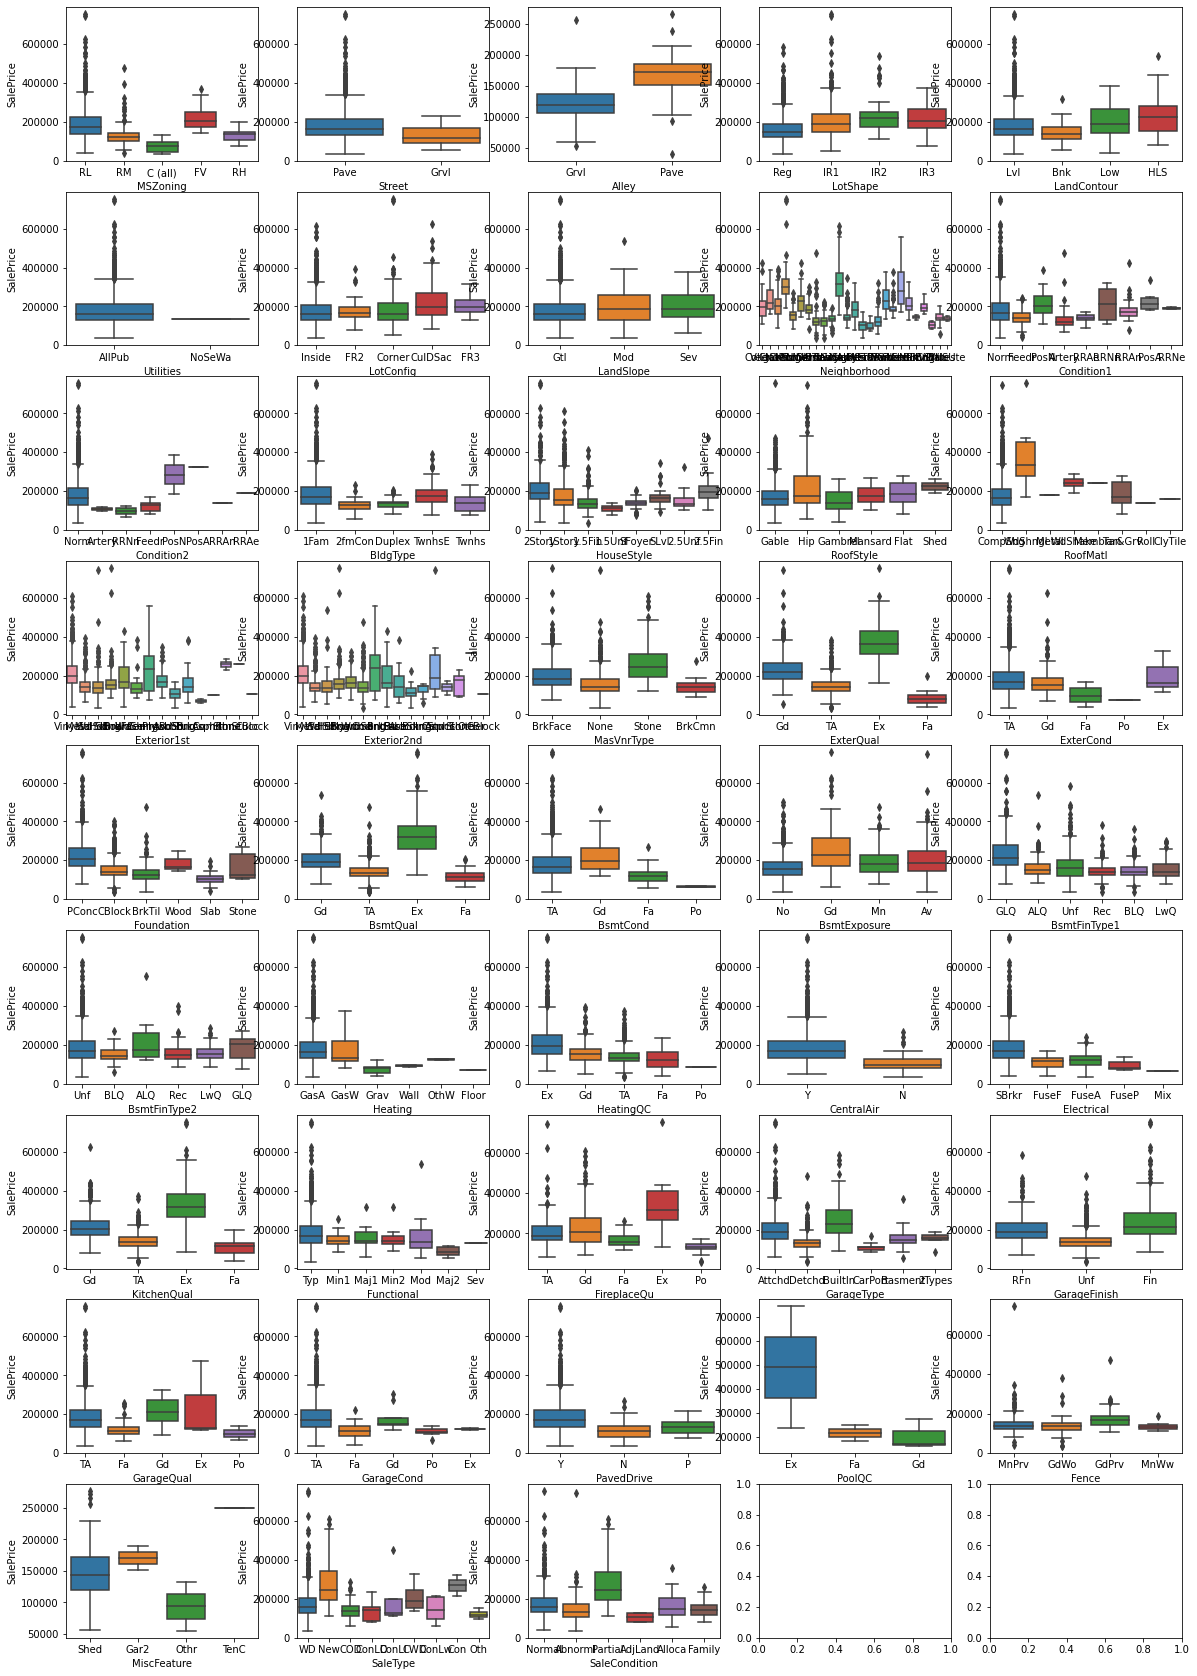

In [80]:
#============== sns.boxplot()
object_feature = df.dtypes[df.dtypes == 'object'].index
print(object_feature)
fig, axs = plt.subplots(figsize=(20,30), ncols=5, nrows=9)
for i, feature in enumerate(object_feature):
    row = int(i / 5) 
    col = i % 5  
    sns.boxplot(x=feature, y='SalePrice', data=df, ax=axs[row][col])

=>그래프를 보고 차이가 많이 안 나는 항목들 삭제

In [81]:
df = df.drop(['Street', 'Utilities', 'LotConfig', 'LandSlope', 'BldgType', 'RoofStyle', 'PavedDrive', 'LotShape', 'LandContour','BsmtFinType2','Fence'], axis=1)
df_t =df_t.drop(['Street', 'Utilities', 'LotConfig', 'LandSlope', 'BldgType', 'RoofStyle', 'PavedDrive', 'LotShape', 'LandContour','BsmtFinType2','Fence'], axis=1)

Index(['MSZoning', 'Alley', 'Neighborhood', 'Condition1', 'Condition2',
       'HouseStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


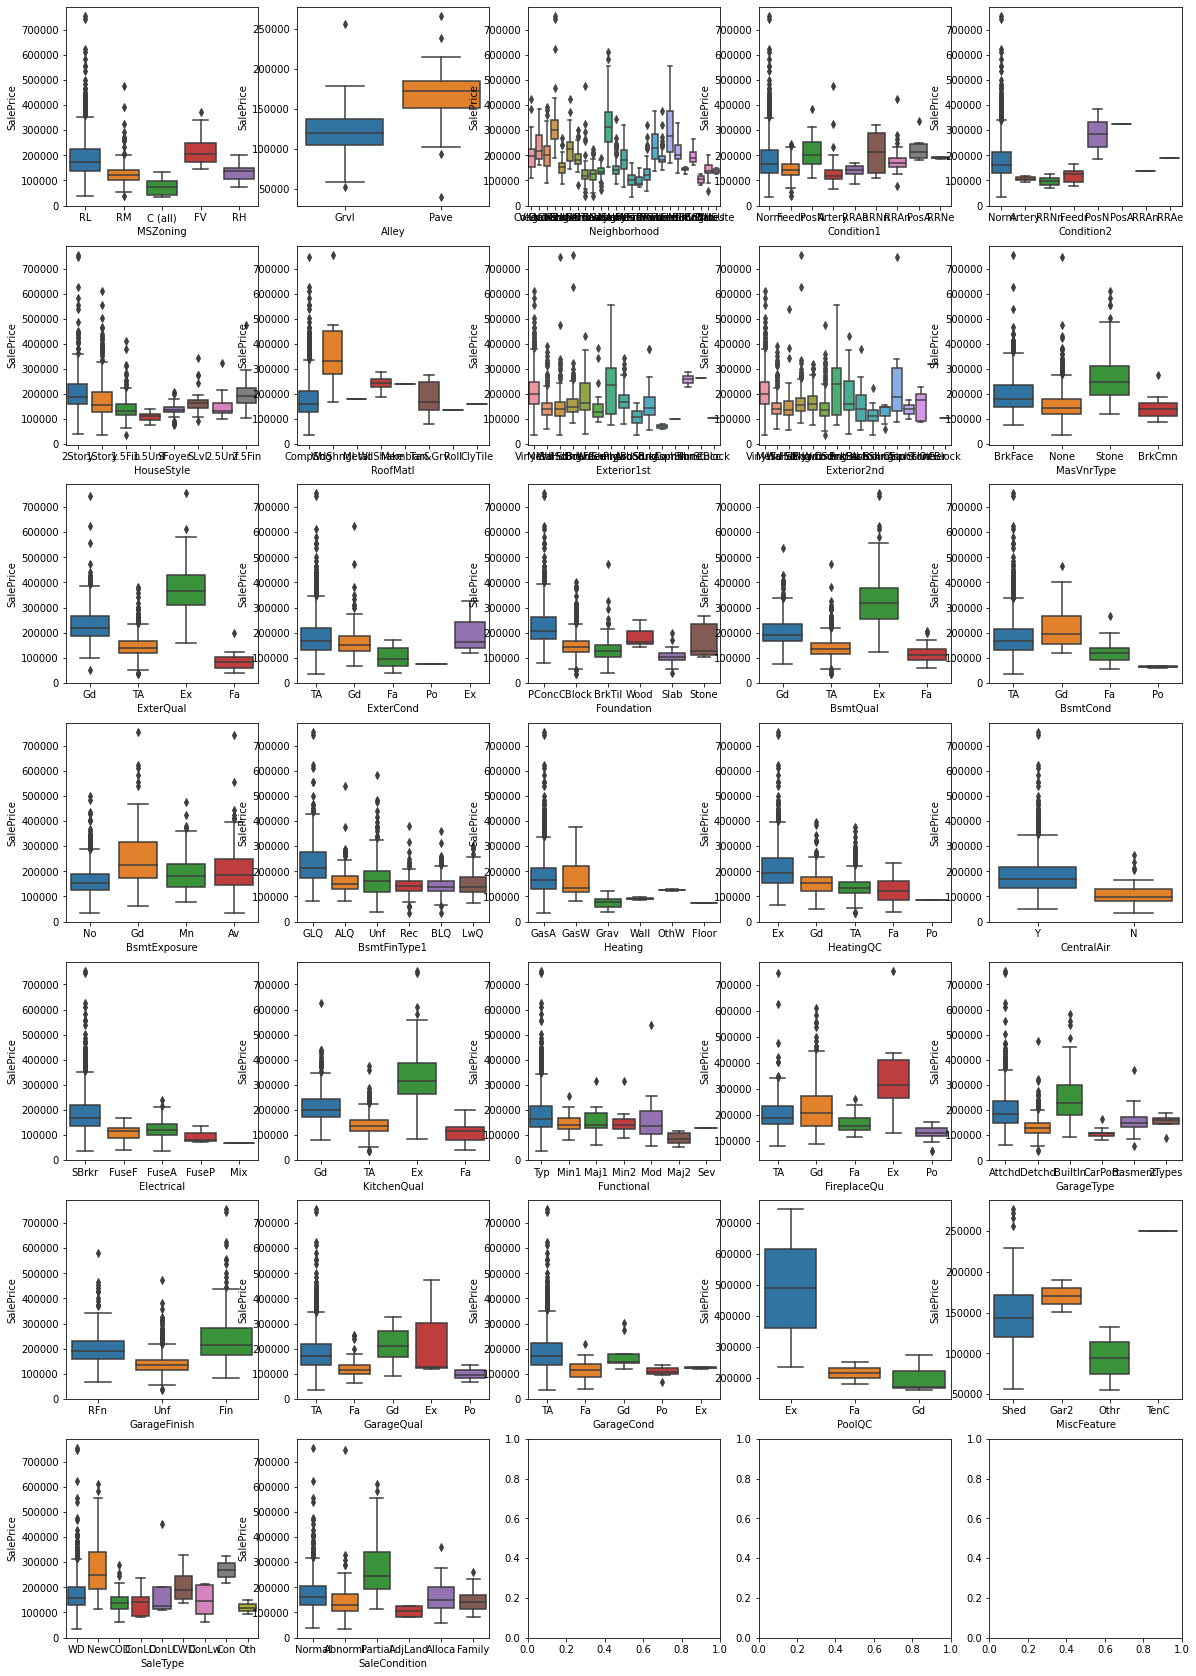

In [82]:
#--> 정확하게 지워졌는지 아닌지 확인
object_feature = df.dtypes[df.dtypes == 'object'].index
print(object_feature)
fig, axs = plt.subplots(figsize=(20,30), ncols=5, nrows=7)
for i, feature in enumerate(object_feature):
    row = int(i / 5) 
    col = i % 5
    # seaborn의 regplot 이용하여 박스플롯
    sns.boxplot(x=feature, y='SalePrice', data=df, ax=axs[row][col])

---------------------------------

### 아웃라이어 삭제 --> 임시보류

IQR (Inter Quartile Range). IQR 이란 상위 75% 지점의 값과 하위 25 지점의 값 차이를 의미한다.

최솟값 : 제 1사분위에서 1.5 IQR1을 뺀 위치이다.
제 1사분위(Q1) : 25%의 위치를 의미한다.
제 2사분위(Q2) : 50%의 위치로 중앙값(median)을 의미한다.
제 3사분위(Q3) : 75%의 위치를 의미한다.
최댓값 : 제 3사분위에서 1.5 IQR을 더한 위치이다.
최솟값과 최댓값을 넘어가는 위치에 있는 값을 이상치(Outlier)라고 부른다.

In [83]:
# # 아웃라이어 탐지 삭제


# from collections import Counter
# def detect_outliers(df2, features):
#     outlier_idx_list = []
#     for col in features:
#         Q1 = np.percentile(df2[col], 25)
#         Q3 = np.percentile(df2[col], 75)
#         IQR = Q3 - Q1
#         IQR15 = 1.5 * IQR
#         outlier_list_col = df2[(df2[col] < Q1 - IQR15) | (df2[col] > Q3 + IQR15)].index
#         outlier_idx_list.extend(outlier_list_col)
#     outlier_idx_list = Counter(outlier_idx_list)
#     # multiple_outliers = list(k for k, v in outlier_idx_list.items() if v > n)
    
#     return outlier_idx_list

In [84]:
# # numeric_feature --> 전처리 전 숫자형 컬럼들 / numeric_feature2 --> 전처리 후 숫자형 컬럼들
# numeric_feature2 = df2.dtypes[df2.dtypes != 'object'].index

In [85]:
# outlier_drop_feature = detect_outliers(df2, numeric_feature2)
# print(outlier_drop_feature)

# print("Outlier 처리전:", df2.shape)
# df2 = df2.drop(outlier_drop_feature, axis = 0).reset_index(drop=True)
# print("Outlier 처리후:", df2.shape)

In [86]:
# X_train.plot(kind='box', subplots=True, figsize=(30, 20), layout=(5,6), sharex=False, sharey=False)
# plt.show()

In [87]:
# outlier_drop_feature_t = detect_outliers(df2_t, 2, numeric_feature2_t)
# print(outlier_drop_feature)

# print("Outlier 처리전:", df2_t.shape)
# df2_t = df2_t.drop(outlier_drop_feature, axis = 0).reset_index(drop=True)
# print("Outlier 처리후:", df2_t.shape)

--------------------------

### 데이터 합치기

-> train과 test에 같은 전처리를 해주기 위함(단, test는 drop에 신중해야 한다.)

In [88]:
data = df.append(df_t)
index = data['Id']
data = data.set_index('Id')
data

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,Neighborhood,Condition1,Condition2,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,NaN,CollgCr,Norm,Norm,2Story,7,5,2003,2003,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,0,61,0,0,0,0,NaN,NaN,0,2,2008,WD,Normal,208500.0
2,20,RL,80.0,9600,NaN,Veenker,Feedr,Norm,1Story,6,8,1976,1976,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,298,0,0,0,0,0,NaN,NaN,0,5,2007,WD,Normal,181500.0
3,60,RL,68.0,11250,NaN,CollgCr,Norm,Norm,2Story,7,5,2001,2002,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,0,42,0,0,0,0,NaN,NaN,0,9,2008,WD,Normal,223500.0
4,70,RL,60.0,9550,NaN,Crawfor,Norm,Norm,2Story,7,5,1915,1970,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,0,35,272,0,0,0,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
5,60,RL,84.0,14260,NaN,NoRidge,Norm,Norm,2Story,8,5,2000,2000,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,192,84,0,0,0,0,NaN,NaN,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,RM,21.0,1936,NaN,MeadowV,Norm,Norm,2Story,4,7,1970,1970,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0,0,0,0,0,0,NaN,NaN,0,6,2006,WD,Normal,NaN
2916,160,RM,21.0,1894,NaN,MeadowV,Norm,Norm,2Story,4,5,1970,1970,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,0,24,0,0,0,0,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2917,20,RL,160.0,20000,NaN,Mitchel,Norm,Norm,1Story,5,7,1960,1996,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,474,0,0,0,0,0,NaN,NaN,0,9,2006,WD,Abnorml,NaN


### 결측치 확인/피쳐삭제/채우기
- 대량의 피쳐 분석의 경우 : 결측치 피쳐(컬럼) 삭제부터 => 컬럼이라 test도 같이 지워도 된다.

뒤에서 null값 비율에따라 drop하기 때문에 SalePrice를 일단 평균값을 채워준다. 

In [89]:
data['SalePrice'].fillna(data['SalePrice'].mean(), inplace=True)
# data['SalePrice'].replace(np.nan, 'None', inplace=True)

In [90]:
# ---------- dataframe 결측치 확인/제거
def null_feature_check(data_f, drop_cnt=None):
    isnull_feature = data_f.isnull().sum()[data_f.isnull().sum()>0].index
    null_df = pd.DataFrame()
    null_df["null_cnt"]  = data_f[isnull_feature].isnull().sum()
    null_df["null_rate"]  = data_f[isnull_feature].isnull().sum() /data_f.shape[0] * 100
    print(null_df)
    
    if drop_cnt != None :
        drop_isnull_feature = data_f.isnull().sum()[data_f.isnull().sum() > drop_cnt].index    
        print("\ndrop_feature:",drop_isnull_feature)
        data_f = data_f.drop(drop_isnull_feature, axis=1)
        print(data_f.shape)
    return data_f

data = null_feature_check(data, 600)

              null_cnt  null_rate
MSZoning             4   0.137033
LotFrontage        486  16.649538
Alley             2721  93.216855
Exterior1st          1   0.034258
Exterior2nd          1   0.034258
MasVnrType          24   0.822199
MasVnrArea          23   0.787941
BsmtQual            81   2.774923
BsmtCond            82   2.809181
BsmtExposure        82   2.809181
BsmtFinType1        79   2.706406
BsmtFinSF1           1   0.034258
BsmtFinSF2           1   0.034258
BsmtUnfSF            1   0.034258
TotalBsmtSF          1   0.034258
Electrical           1   0.034258
BsmtFullBath         2   0.068517
BsmtHalfBath         2   0.068517
KitchenQual          1   0.034258
Functional           2   0.068517
FireplaceQu       1420  48.646797
GarageType         157   5.378554
GarageYrBlt        159   5.447071
GarageFinish       159   5.447071
GarageCars           1   0.034258
GarageArea           1   0.034258
GarageQual         159   5.447071
GarageCond         159   5.447071
PoolQC        

In [91]:
data.fillna(data.mean(), inplace=True)
data.replace(np.nan, 'None', inplace=True)
data = null_feature_check(data)

Empty DataFrame
Columns: [null_cnt, null_rate]
Index: []


In [92]:
#확인용
data[['BsmtFinSF2', 'BsmtFinSF1']].isnull().sum()

BsmtFinSF2    0
BsmtFinSF1    0
dtype: int64

In [93]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [94]:
numeric_feature = ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice']

In [95]:
vif_data = data[numeric_feature].iloc[:,:-1]
vif_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 36 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   LotFrontage    2919 non-null   float64
 2   LotArea        2919 non-null   int64  
 3   OverallQual    2919 non-null   int64  
 4   OverallCond    2919 non-null   int64  
 5   YearBuilt      2919 non-null   int64  
 6   YearRemodAdd   2919 non-null   int64  
 7   MasVnrArea     2919 non-null   float64
 8   BsmtFinSF1     2919 non-null   float64
 9   BsmtFinSF2     2919 non-null   float64
 10  BsmtUnfSF      2919 non-null   float64
 11  TotalBsmtSF    2919 non-null   float64
 12  1stFlrSF       2919 non-null   int64  
 13  2ndFlrSF       2919 non-null   int64  
 14  LowQualFinSF   2919 non-null   int64  
 15  GrLivArea      2919 non-null   int64  
 16  BsmtFullBath   2919 non-null   float64
 17  BsmtHalfBath   2919 non-null   float64
 18  FullBath

In [96]:
vif = pd.DataFrame()
vif['Features'] = vif_data.columns
vif['vif'] = [variance_inflation_factor(
             vif_data.values, i) for i in range(vif_data.shape[1])]
vif.sort_values(by='vif',ascending=False)

,Features,vif
9,BsmtFinSF2,inf
8,BsmtFinSF1,inf
15,GrLivArea,inf
14,LowQualFinSF,inf
13,2ndFlrSF,inf
12,1stFlrSF,inf
11,TotalBsmtSF,inf
10,BsmtUnfSF,inf
35,YrSold,2.300868e+04
6,YearRemodAdd,2.197346e+04


In [97]:
from sklearn.decomposition import PCA
from scipy.stats import norm

[0.87921869]
<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>


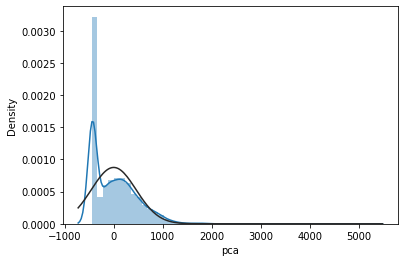

In [98]:
pca=PCA(n_components=1)
pca.fit(data[['BsmtFinSF2', 'BsmtFinSF1']])
print(pca.explained_variance_ratio_)

data['pca']=pca.fit_transform(data[['BsmtFinSF2', 'BsmtFinSF1']])

sns.distplot(data['pca'], fit=norm)
print(plt)

[0.99174306]
<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>


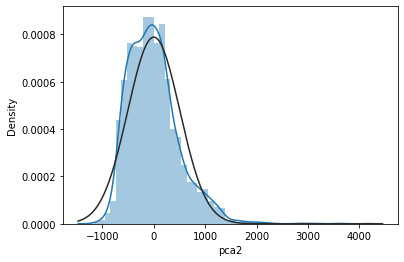

In [99]:
pca2=PCA(n_components=1)
pca2.fit(data[['LowQualFinSF', 'GrLivArea']])
print(pca2.explained_variance_ratio_)

data['pca2']=pca2.fit_transform(data[['LowQualFinSF', 'GrLivArea']])

sns.distplot(data['pca2'], fit=norm)
print(plt)

[0.63203157]
<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>


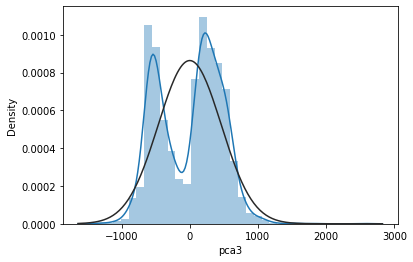

In [100]:
pca3=PCA(n_components=1)
pca3.fit(data[['2ndFlrSF', '1stFlrSF']])
print(pca3.explained_variance_ratio_)

data['pca3']=pca3.fit_transform(data[['2ndFlrSF', '1stFlrSF']])

sns.distplot(data['pca3'], fit=norm)
print(plt)

[0.70614633]
<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>


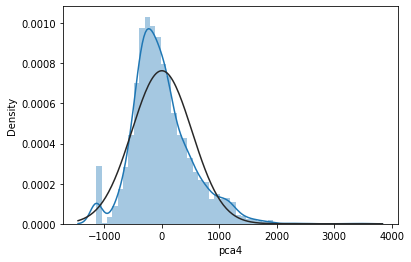

In [101]:
pca4=PCA(n_components=1)
pca4.fit(data[['TotalBsmtSF', 'BsmtUnfSF']])
print(pca4.explained_variance_ratio_)

data['pca4']=pca4.fit_transform(data[['TotalBsmtSF', 'BsmtUnfSF']])

sns.distplot(data['pca4'], fit=norm)
print(plt)

[0.8367895]
<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>


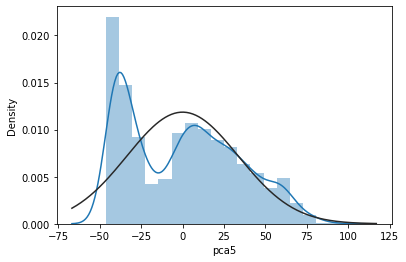

In [102]:
pca5=PCA(n_components=1)
pca5.fit(data[['YearBuilt', 'YearRemodAdd']])
print(pca5.explained_variance_ratio_)

data['pca5']=pca5.fit_transform(data[['YearBuilt', 'YearRemodAdd']])

sns.distplot(data['pca5'], fit=norm)
print(plt)

[0.62468889]
<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>


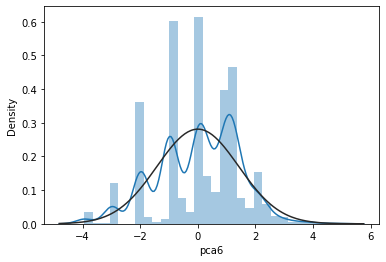

In [103]:
pca6=PCA(n_components=1)
pca6.fit(data[['OverallQual', 'OverallCond']])
print(pca6.explained_variance_ratio_)

data['pca6']=pca6.fit_transform(data[['OverallQual', 'OverallCond']])

sns.distplot(data['pca6'], fit=norm)
print(plt)

[0.99999739]
<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>


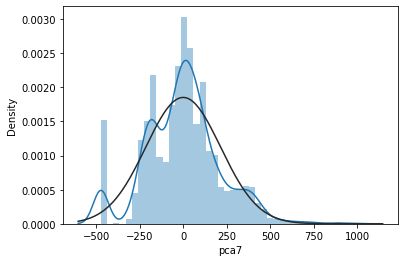

In [104]:
pca7=PCA(n_components=1)
pca7.fit(data[['GarageCars', 'GarageArea']])
print(pca7.explained_variance_ratio_)

data['pca7']=pca7.fit_transform(data[['GarageCars', 'GarageArea']])

sns.distplot(data['pca7'], fit=norm)
print(plt)

In [105]:
object_feature, numeric_feature = type_check(data)

object     28
int64      25
float64    19
dtype: int64
object type: Index(['MSZoning', 'Neighborhood', 'Condition1', 'Condition2', 'HouseStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'SaleType', 'SaleCondition'],
      dtype='object')
numeric type: Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'E

- 다중공선성 의심되어 삭제될 컬럼: 'BsmtFinSF2', 'BsmtFinSF1', 'LowQualFinSF', 'GrLivArea', 'TotalBsmtSF', 'BsmtUnfSF', 'YearBuilt', 'YearRemodAdd', 'OverallQual', 'OverallCond'

- pca3은 그대로 두기로 결정

In [106]:
# pca를 새로 생성하면서 지우게 된 컬럼들

drop_list = ['pca3', 'BsmtFinSF2', 'BsmtFinSF1', 'LowQualFinSF', 'GrLivArea', 'TotalBsmtSF', 'BsmtUnfSF', 'YearBuilt', 'YearRemodAdd', 'OverallQual', 'OverallCond']
data = data.drop(drop_list, axis=1)

### 수치형 피쳐 데이터값 확인

In [107]:
object_feature, numeric_feature = type_check(data)

object     28
int64      19
float64    14
dtype: int64
object type: Index(['MSZoning', 'Neighborhood', 'Condition1', 'Condition2', 'HouseStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'SaleType', 'SaleCondition'],
      dtype='object')
numeric type: Index(['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', '1stFlrSF',
       '2ndFlrSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice', 'pca', 'pca2', 'pca4', 'pca5', 'pca6',
       'pca7'

In [108]:
data[numeric_feature].head(10).T

Id,1,2,3,4,5,6,7,8,9,10
MSSubClass,60.000000,20.000000,60.000000,70.000000,60.000000,50.000000,20.000000,60.000000,50.000000,190.000000
LotFrontage,65.000000,80.000000,68.000000,60.000000,84.000000,85.000000,75.000000,69.305795,51.000000,50.000000
LotArea,8450.000000,9600.000000,11250.000000,9550.000000,14260.000000,14115.000000,10084.000000,10382.000000,6120.000000,7420.000000
MasVnrArea,196.000000,0.000000,162.000000,0.000000,350.000000,0.000000,186.000000,240.000000,0.000000,0.000000
1stFlrSF,856.000000,1262.000000,920.000000,961.000000,1145.000000,796.000000,1694.000000,1107.000000,1022.000000,1077.000000
2ndFlrSF,854.000000,0.000000,866.000000,756.000000,1053.000000,566.000000,0.000000,983.000000,752.000000,0.000000
BsmtFullBath,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
BsmtHalfBath,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FullBath,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,2.000000,2.000000,1.000000
HalfBath,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000


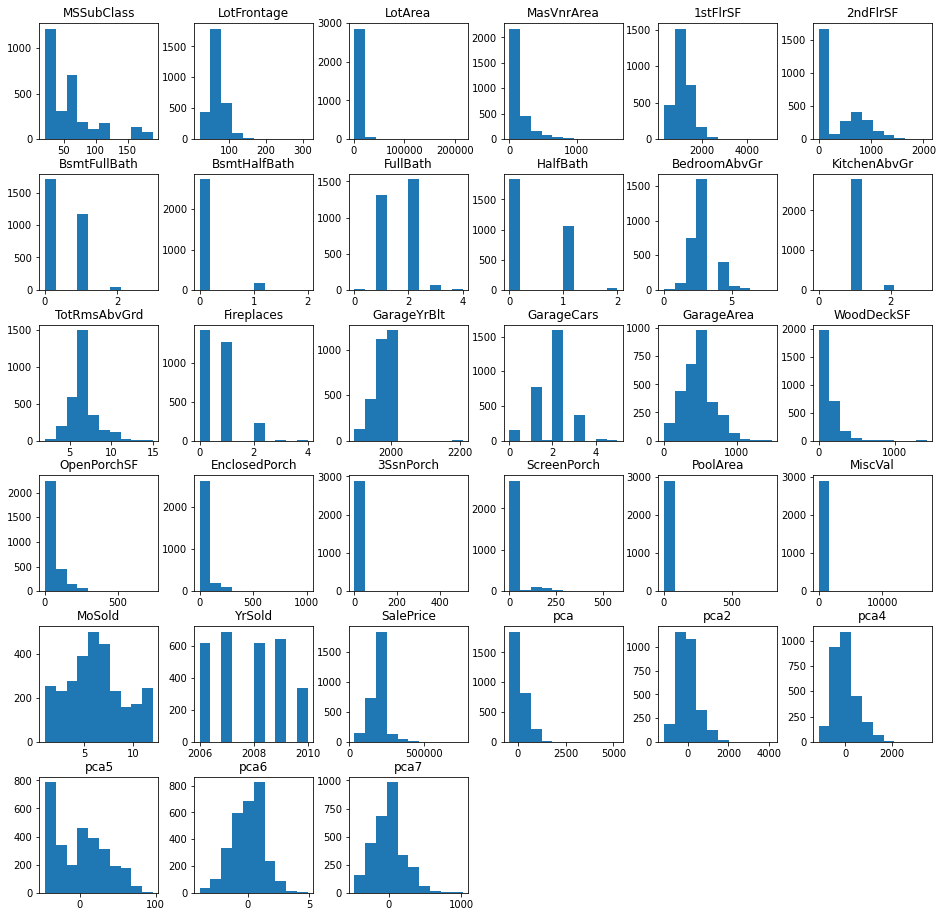

In [109]:
data.hist(bins=10, figsize=(16,16), grid=False);
plt.show()

### Object형 시각화

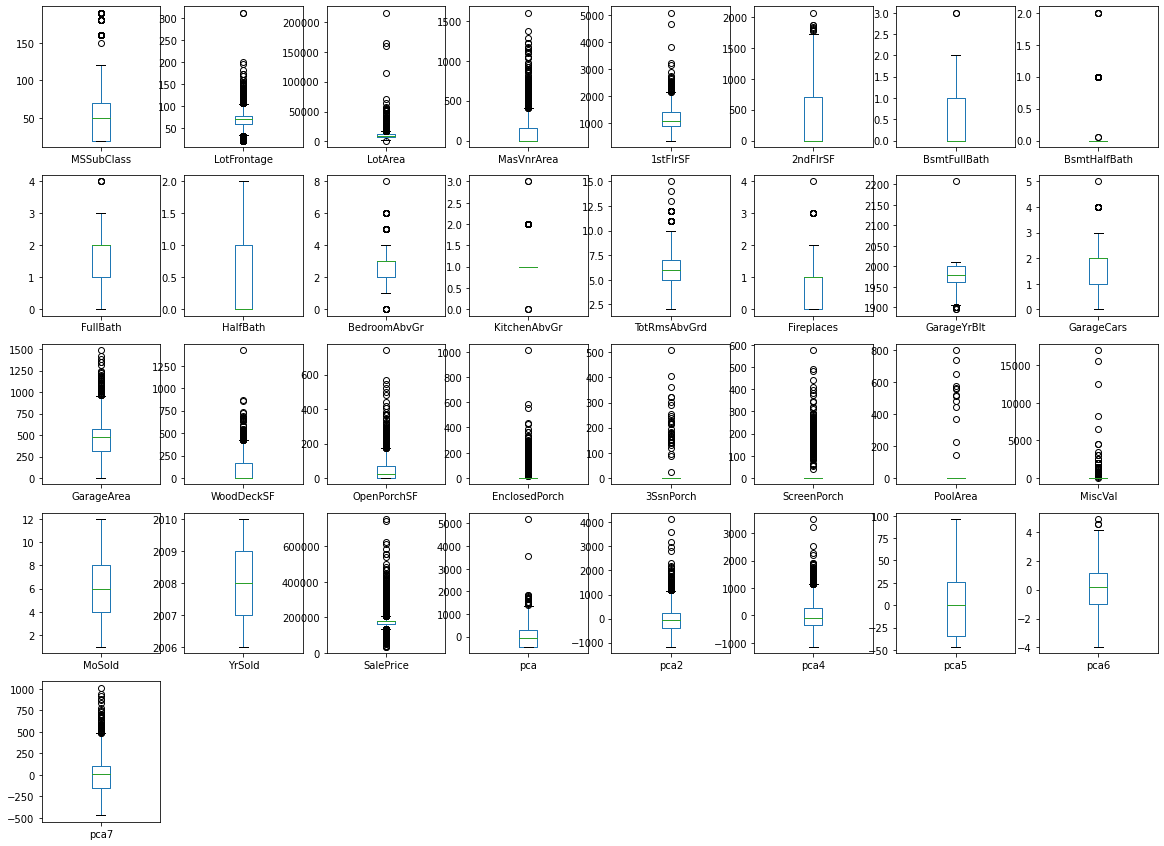

In [110]:
data.plot(kind='box', subplots=True, figsize=(20, 15), layout=(5,8), sharex=False, sharey=False)
plt.show()

In [111]:
# 아웃라이어 값이 전체이므로 삭제처리할 리스트
outlier_list = ['EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal']

data = data.drop(outlier_list, axis=1)

### 숫자 모양의 object형 피쳐 인코딩

In [112]:
object_feature, numeric_feature = type_check(data)

object     28
int64      15
float64    14
dtype: int64
object type: Index(['MSZoning', 'Neighborhood', 'Condition1', 'Condition2', 'HouseStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'SaleType', 'SaleCondition'],
      dtype='object')
numeric type: Index(['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', '1stFlrSF',
       '2ndFlrSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'PoolArea', 'MoSold', 'YrSold', 'SalePrice', 'pca', 'pca2', 'pca4',
       'pca5', 'pca6', 'pca7'],
      dtype='object')


#### 원-핫 인코딩은 간단히 말해 한 개의 요소는 True, 나머지 요소는 False로 만들어 주는 기법이다.

※ 원-핫 인코딩이 필요한 이유?
scikit-learn에서 제공하는 머신러닝 알고리즘은 문자열 값을 입력 값으로 허락하지 않기 때문에 모든 문자열 값들을 숫자형으로 인코딩하는 전처리 작업(Preprocessing) 후에 머신러닝 모델에 학습을 시켜야 한다.

scikit-learn 에서 제공하는 머신러닝 알고리즘에 데이터를 넣을 수 있는 기본 조건은 다음과 같다.
– 모든 데이터는 숫자(정수형, 실수형 등)로 구성되어 있어야 한다.
– 데이터에 빈 값이 없어야 한다.

- nunique가 15개보다 작다는것은 숫자로 된 범주형일 확률이 높다는 뜻이다. => 범주형 찾아서 원핫인코딩
- 다만, 그 안에서도 범주형으로 보기 애매한게 있을 수 있으므로 주의해야 한다.

In [113]:
# select distinct deptno from emp;
#수치형 : 0/1/2 코드성 수치
oh_numeric_feature = []
for col in numeric_feature:
    if data[col].nunique() <= 15:
        print(col, data[col].unique())
        oh_numeric_feature.append(col)
print("인코딩 적용 전 :",data.shape)

oh_numeric_feature.remove('PoolArea')
print("인코딩 대상 피쳐 :", oh_numeric_feature)

data_oh = pd.get_dummies(data=data, columns=oh_numeric_feature)
print("인코딩 적용 후 :",data_oh.shape)
print(data_oh.head())

BsmtFullBath [1.         0.         2.         3.         0.42989373]
BsmtHalfBath [0.         1.         2.         0.06136442]
FullBath [2 1 3 0 4]
HalfBath [1 0 2]
BedroomAbvGr [3 4 1 2 0 5 6 8]
KitchenAbvGr [1 2 3 0]
TotRmsAbvGrd [ 8  6  7  9  5 11  4 10 12  3  2 14 13 15]
Fireplaces [0 1 2 3 4]
GarageCars [2.         3.         1.         0.         4.         5.
 1.76662097]
PoolArea [  0 512 648 576 555 480 519 738 144 368 444 228 561 800]
MoSold [ 2  5  9 12 10  8 11  4  1  7  3  6]
YrSold [2008 2007 2006 2009 2010]
인코딩 적용 전 : (2919, 57)
인코딩 대상 피쳐 : ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'MoSold', 'YrSold']
인코딩 적용 후 : (2919, 118)
    MSSubClass MSZoning  LotFrontage  ...  YrSold_2008 YrSold_2009 YrSold_2010
Id                                    ...                                     
1           60       RL         65.0  ...            1           0           0
2           20       RL

In [114]:
object_feature, numeric_feature = type_check(data_oh)

uint8      72
object     28
float64    11
int64       7
dtype: int64
object type: Index(['MSZoning', 'Neighborhood', 'Condition1', 'Condition2', 'HouseStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'SaleType', 'SaleCondition'],
      dtype='object')
numeric type: Index(['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', '1stFlrSF',
       '2ndFlrSF', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'PoolArea', 'SalePrice', 'pca', 'pca2', 'pca4', 'pca5', 'pca6', 'pca7',
       'BsmtFullBath_0.0', 'BsmtFullBath_0.429893726431265',
       'BsmtFullBath_1.0', 'BsmtFullBath_2.0', 'BsmtFullBath_3.0',
       'BsmtHalfBath_0.0', 'BsmtHalfBath_0.06136441549537196',
       'BsmtHalfBath_1.0', 'B

### 수치형 정규화
타켓 분포도 확인/정규화

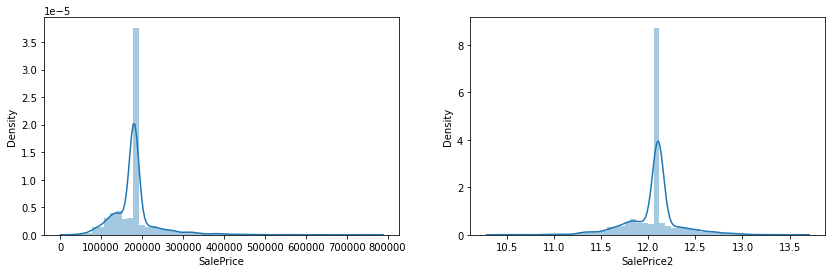

In [115]:
# MinMaxScaler: 0 ~ 1
# StandardScaler: 평균0 분산1(정규분포)
# np.log()
#  : max을 0으로두고 다른값을 뺀 그 차이값을 이용
# np.log1p()
# : log를 취한값이 너무 작으면 언더플로우가 나기 때문에 1을 더해서 사용

data_oh['SalePrice2'] = np.log1p(data_oh['SalePrice'])

f, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
sns.distplot(data_oh['SalePrice'],  ax=axes[0])
sns.distplot(data_oh['SalePrice2'], ax=axes[1])
plt.show()

=> SalePrice를 임의로 평균값으로 채웠기 때문에 혼자 쏫아있다.

### 수치형 피쳐 : skew() kurt() 왜도/첨도확인

왜도(비대칭도)란, 확률변수의 확률분포가 비대칭성을 의미한다
a=0이면 정규분포, a<0이면 오른쪽으로 치우침, a>0이면 왼쪽으로 치우침을 의미한다.

첨도란(Kurtosis), 확률분포의 뾰족한 정도를 의미한다
a=3이면 정규분포, a<3이면 정규분포보다 완만함, a>3이면 정규분포 보다 뾰족함을 의미한다.

In [116]:
#============== skew() kurt() 왜도/첨도 확인
sk_df = pd.DataFrame()

#왜도 : 대칭=0(정규분포) <0 :오른쪽편중  >0:왼쪽편중
sk_df["skew"] = data_oh[numeric_feature].skew()
#첨도 : 뾰족함(중앙 편중)
sk_df["kurt"] = data_oh[numeric_feature].kurt()
print(sk_df.head(40).sort_values("skew", ascending=False))

                                       skew         kurt
BsmtFullBath_0.429893726431265    38.183753  1456.997257
BsmtHalfBath_0.06136441549537196  38.183753  1456.997257
BsmtFullBath_3.0                  38.183753  1456.997257
BsmtHalfBath_2.0                  26.972189   725.996401
FullBath_4                        26.972189   725.996401
BedroomAbvGr_0                    19.032867   360.497008
PoolArea                          16.907017   298.633144
FullBath_0                        15.508104   238.664799
LotArea                           12.829025   264.952310
HalfBath_2                        10.671723   111.962383
BsmtFullBath_2.0                   8.596797    71.954227
FullBath_3                         6.532660    40.703535
BedroomAbvGr_1                     5.040088    23.418532
BsmtHalfBath_1.0                   3.761242    12.155268
SalePrice                          2.660964    16.042632
MasVnrArea                         2.612892     9.351548
OpenPorchSF                    

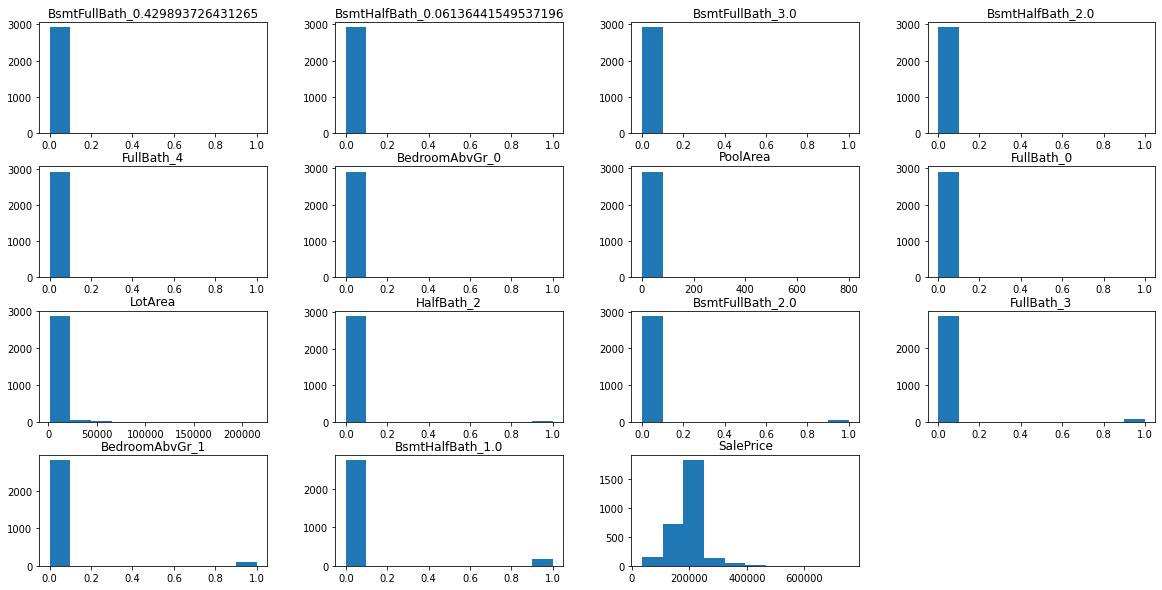

In [117]:
skew_feature = sk_df.head(40).sort_values("skew", ascending=False)[:15].index

data_oh[skew_feature].hist(bins=10, figsize=(20,10), grid=False)
plt.show()

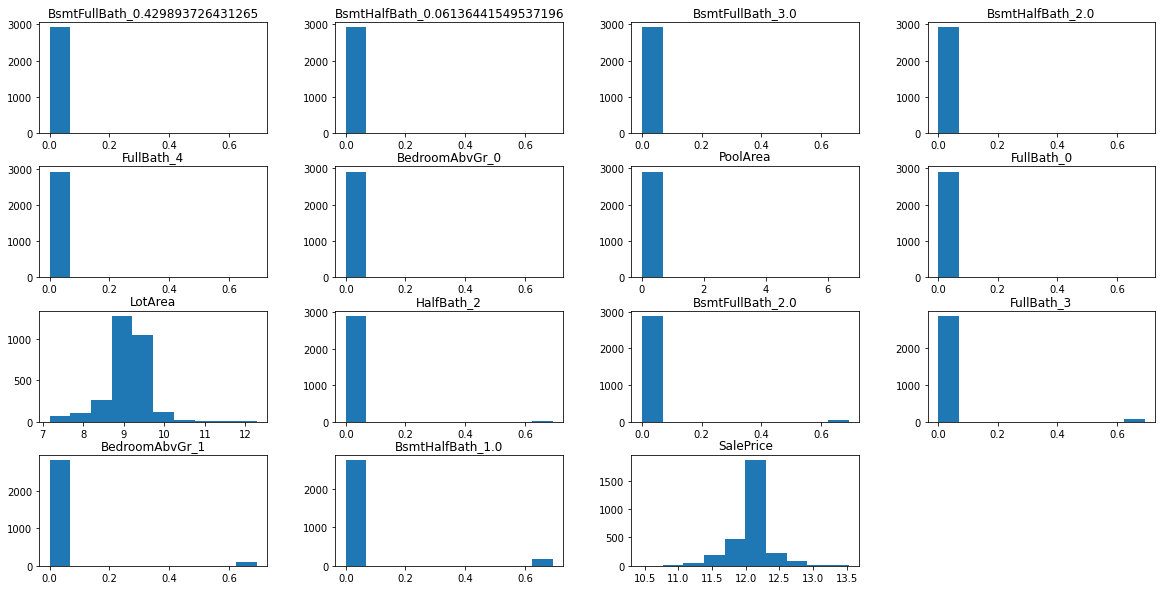

In [118]:
for col in skew_feature:
    data_oh[col] = np.log1p(data_oh[col]) #그냥 log보다 log1p는 엄청 작은 값도 잡아준다.
data_oh[skew_feature].hist(bins=10, figsize=(20,10), grid=False)
plt.show()

In [119]:
data_oh

,MSSubClass,MSZoning,LotFrontage,LotArea,Neighborhood,Condition1,Condition2,HouseStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,KitchenQual,Functional,GarageType,GarageYrBlt,GarageFinish,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,PoolArea,SaleType,SaleCondition,SalePrice,...,TotRmsAbvGrd_6,TotRmsAbvGrd_7,TotRmsAbvGrd_8,TotRmsAbvGrd_9,TotRmsAbvGrd_10,TotRmsAbvGrd_11,TotRmsAbvGrd_12,TotRmsAbvGrd_13,TotRmsAbvGrd_14,TotRmsAbvGrd_15,Fireplaces_0,Fireplaces_1,Fireplaces_2,Fireplaces_3,Fireplaces_4,GarageCars_0.0,GarageCars_1.0,GarageCars_1.7666209732693625,GarageCars_2.0,GarageCars_3.0,GarageCars_4.0,GarageCars_5.0,MoSold_1,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,SalePrice2
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,9.042040,CollgCr,Norm,Norm,2Story,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,GasA,Ex,Y,SBrkr,856,854,Gd,Typ,Attchd,2003.000000,RFn,548.0,TA,TA,0,61,0.0,WD,Normal,12.247699,...,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,12.247699
2,20,RL,80.0,9.169623,Veenker,Feedr,Norm,1Story,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,GasA,Ex,Y,SBrkr,1262,0,TA,Typ,Attchd,1976.000000,RFn,460.0,TA,TA,298,0,0.0,WD,Normal,12.109016,...,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,12.109016
3,60,RL,68.0,9.328212,CollgCr,Norm,Norm,2Story,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,GasA,Ex,Y,SBrkr,920,866,Gd,Typ,Attchd,2001.000000,RFn,608.0,TA,TA,0,42,0.0,WD,Normal,12.317171,...,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,12.317171
4,70,RL,60.0,9.164401,Crawfor,Norm,Norm,2Story,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,GasA,Gd,Y,SBrkr,961,756,Gd,Typ,Detchd,1998.000000,Unf,642.0,TA,TA,0,35,0.0,WD,Abnorml,11.849405,...,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,11.849405
5,60,RL,84.0,9.565284,NoRidge,Norm,Norm,2Story,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,GasA,Ex,Y,SBrkr,1145,1053,Gd,Typ,Attchd,2000.000000,RFn,836.0,TA,TA,192,84,0.0,WD,Normal,12.429220,...,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,12.429220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,RM,21.0,7.568896,MeadowV,Norm,Norm,2Story,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,GasA,Gd,Y,SBrkr,546,546,TA,Typ,None,1978.113406,None,0.0,None,None,0,0,0.0,WD,Normal,12.105822,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,12.105822
2916,160,RM,21.0,7.546974,MeadowV,Norm,Norm,2Story,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,GasA,TA,Y,SBrkr,546,546,TA,Typ,CarPort,1970.000000,Unf,286.0,TA,TA,0,24,0.0,WD,Abnorml,12.105822,...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,12.105822
2917,20,RL,160.0,9.903538,Mitchel,Norm,Norm,1Story,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,GasA,Ex,Y,SBrkr,1224,0,TA,Typ,Detchd,1960.000000,Unf,576.0,TA,TA,474,0,0.0,WD,Abnorml,12.105822,...,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,12.105822


### 9. Object형 피쳐 인코딩

- 만약 시작할 때 train test를 안 합친 경우에는 인코딩 전 test와 train 합치기 ! 
- pd.get_dummy() --> dummy는 행을 열에 늘리는 거니까 train하고 test하고 행이 다른 상황이라 합쳐서 더미를 하고 나눠야 하기 때문

In [120]:
# Object Type : 
# LabelEncoding (Pool Extend ... Excellent : 0 1 ... 33)
# OneHotEncoding (1000 0100  0010 0001) :피쳐가 엄청~ 많아진다(시각화X, 분석용)

print("인코딩 적용 전 :",data_oh.shape)
data_oh = pd.get_dummies(data=data_oh, columns=object_feature)
print("인코딩 적용 후 :",data_oh.shape)

인코딩 적용 전 : (2919, 119)
인코딩 적용 후 : (2919, 300)


### train, test 나누기

In [121]:
X_train = data_oh[:1460]
X_test = data_oh[1460:]

In [122]:
X_train

,MSSubClass,LotFrontage,LotArea,MasVnrArea,1stFlrSF,2ndFlrSF,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,PoolArea,SalePrice,pca,pca2,pca4,pca5,pca6,pca7,BsmtFullBath_0.0,BsmtFullBath_0.429893726431265,BsmtFullBath_1.0,BsmtFullBath_2.0,BsmtFullBath_3.0,BsmtHalfBath_0.0,BsmtHalfBath_0.06136441549537196,BsmtHalfBath_1.0,BsmtHalfBath_2.0,FullBath_0,FullBath_1,FullBath_2,FullBath_3,FullBath_4,HalfBath_0,HalfBath_1,HalfBath_2,BedroomAbvGr_0,BedroomAbvGr_1,BedroomAbvGr_2,BedroomAbvGr_3,BedroomAbvGr_4,...,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_None,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,9.042040,196.0,856,854,2003.0,548.0,0,61,0.0,12.247699,265.677269,209.189690,-428.380864,-36.798946,-1.000156,75.125791,0,0.0,1,0.0,0.0,1,0.0,0.000000,0.0,0.0,0,1,0.0,0.0,0,1,0.0,0.0,0.0,0,1,0,...,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,20,80.0,9.169623,0.0,1262,0,1976.0,460.0,298,0,0.0,12.109016,537.600910,-238.792327,-45.897483,-0.078397,0.541200,-12.873774,1,0.0,0,0.0,0.0,0,0.0,0.693359,0.0,0.0,0,1,0.0,0.0,1,0,0.0,0.0,0.0,0,1,0,...,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,60,68.0,9.328212,162.0,920,866,2001.0,608.0,0,42,0.0,12.317171,45.739030,285.186639,-182.833126,-34.565044,-1.000156,135.125494,0,0.0,1,0.0,0.0,1,0.0,0.000000,0.0,0.0,0,1,0.0,0.0,0,1,0.0,0.0,0.0,0,1,0,...,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,70,60.0,9.164401,0.0,961,756,1998.0,642.0,0,35,0.0,11.849405,-224.185172,216.189409,-224.488208,56.145218,-1.000156,169.128472,0,0.0,1,0.0,0.0,1,0.0,0.000000,0.0,0.0,1,0,0.0,0.0,1,0,0.0,0.0,0.0,0,1,0,...,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
5,60,84.0,9.565284,350.0,1145,1053,2000.0,836.0,192,84,0.0,12.429220,214.691586,697.170101,16.265299,-32.718885,-1.982652,363.127512,0,0.0,1,0.0,0.0,1,0.0,0.000000,0.0,0.0,0,1,0.0,0.0,0,1,0.0,0.0,0.0,0,0,1,...,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,62.0,8.976894,0.0,953,694,1999.0,460.0,0,40,0.0,12.072547,-440.124534,146.192219,206.329984,-31.845003,-0.017661,-12.873774,1,0.0,0,0.0,0.0,1,0.0,0.000000,0.0,0.0,0,1,0.0,0.0,0,1,0.0,0.0,0.0,0,1,0,...,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1457,20,85.0,9.486152,119.0,2073,0,1978.0,500.0,349,0,0.0,12.254868,345.791640,572.175119,367.698088,-7.659824,0.168626,27.126028,0,0.0,1,0.0,0.0,1,0.0,0.000000,0.0,0.0,0,1,0.0,0.0,1,0,0.0,0.0,0.0,0,1,0,...,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1458,70,66.0,9.109746,0.0,1188,1152,1941.0,252.0,0,60,0.0,12.493133,-165.201736,839.164401,293.958656,15.923302,-0.255009,-220.875890,1,0.0,0,0.0,0.0,1,0.0,0.000000,0.0,0.0,0,1,0.0,0.0,1,0,0.0,0.0,0.0,0,0,1,...,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [123]:
X_test

,MSSubClass,LotFrontage,LotArea,MasVnrArea,1stFlrSF,2ndFlrSF,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,PoolArea,SalePrice,pca,pca2,pca4,pca5,pca6,pca7,BsmtFullBath_0.0,BsmtFullBath_0.429893726431265,BsmtFullBath_1.0,BsmtFullBath_2.0,BsmtFullBath_3.0,BsmtHalfBath_0.0,BsmtHalfBath_0.06136441549537196,BsmtHalfBath_1.0,BsmtHalfBath_2.0,FullBath_0,FullBath_1,FullBath_2,FullBath_3,FullBath_4,HalfBath_0,HalfBath_1,HalfBath_2,BedroomAbvGr_0,BedroomAbvGr_1,BedroomAbvGr_2,BedroomAbvGr_3,BedroomAbvGr_4,...,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_None,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1461,20,80.0,9.360741,0.0,896,0,1961.000000,730.0,140,0,0.0,12.105822,24.332213,-604.777635,-325.367762,20.321909,1.151121,257.121744,1,0.0,0,0.0,0.0,1,0.0,0.000000,0.0,0.0,1,0,0.0,0.0,1,0,0.0,0.0,0.0,1,0,0,...,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1462,20,81.0,9.565775,108.0,1329,0,1958.000000,312.0,393,36,0.0,12.105822,482.616350,-171.795016,87.613934,24.401970,0.168626,-160.876187,1,0.0,0,0.0,0.0,1,0.0,0.000000,0.0,0.0,1,0,0.0,0.0,0,1,0.0,0.0,0.0,0,1,0,...,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1463,60,74.0,9.534668,0.0,928,701,1997.000000,482.0,212,34,0.0,12.105822,350.653407,128.192941,-386.459337,-29.124963,0.964835,9.126117,1,0.0,0,0.0,0.0,1,0.0,0.000000,0.0,0.0,0,1,0.0,0.0,0,1,0.0,0.0,0.0,0,1,0,...,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1464,60,78.0,9.208238,20.0,926,678,1998.000000,470.0,360,36,0.0,12.105822,161.706465,103.193945,-256.095510,-29.998844,0.168626,-2.873823,1,0.0,0,0.0,0.0,1,0.0,0.000000,0.0,0.0,0,1,0.0,0.0,0,1,0.0,0.0,0.0,0,1,0,...,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1465,120,43.0,8.518392,0.0,1280,0,1992.000000,506.0,0,82,0.0,12.105822,-177.198367,-220.793049,483.433615,-21.838722,-1.982652,33.125999,1,0.0,0,0.0,0.0,1,0.0,0.000000,0.0,0.0,0,1,0.0,0.0,1,0,0.0,0.0,0.0,1,0,0,...,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,21.0,7.568896,0.0,546,546,1978.113406,0.0,0,0,0.0,12.105822,-440.124534,-408.785503,-369.251670,8.081726,2.319904,-472.877789,1,0.0,0,0.0,0.0,1,0.0,0.000000,0.0,0.0,1,0,0.0,0.0,0,1,0.0,0.0,0.0,0,1,0,...,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2916,160,21.0,7.546974,0.0,546,546,1970.000000,286.0,0,24,0.0,12.105822,-188.195279,-408.785503,-546.841321,8.081726,1.947330,-186.876059,1,0.0,0,0.0,0.0,1,0.0,0.000000,0.0,0.0,1,0,0.0,0.0,0,1,0.0,0.0,0.0,0,1,0,...,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
2917,20,160.0,9.903538,0.0,1224,0,1960.000000,576.0,474,0,0.0,12.105822,783.531850,-276.790801,-272.998620,4.180937,1.337408,103.125652,0,0.0,1,0.0,0.0,1,0.0,0.000000,0.0,0.0,1,0,0.0,0.0,1,0,0.0,0.0,0.0,0,0,1,...,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0


In [124]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Columns: 300 entries, MSSubClass to SaleCondition_Partial
dtypes: float16(12), float64(14), int64(5), uint8(269)
memory usage: 645.9 KB


In [125]:
X_test = X_test.drop(['SalePrice','SalePrice2'], axis=1)

In [126]:
y_train = X_train['SalePrice']

In [127]:
X_train = X_train.drop(['SalePrice','SalePrice2'], axis=1)

### 학습모델 선정 / 평가

In [128]:
# ---- 개별 분류 모델 -------------------
lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()

for model_name, model in [("LR", lr), ("Ridge", ridge), ("Lasso", lasso)]:
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print(model_name , pred)

LR [11.72943115 11.99786377 12.14959717 ... 12.01324463 11.7477417
 12.25640869]
Ridge [11.70301192 11.97693999 12.11405074 ... 11.9713465  11.74112337
 12.26993673]
Lasso [11.81826706 11.93916235 12.17552058 ... 12.07514971 11.71110615
 12.34955008]


In [129]:
#----- cross_val_score-------

for model_name, model in [("LR", lr), ("Ridge", ridge), ("Lasso", lasso)]:
    neg_mse_scores = cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5)
    rmse_scores  = np.sqrt(-1 * neg_mse_scores) #차이를 극대화해서 보려고 neg를 쓰므로 -1해서 양수로 바꿔야함
    avg_rmse = np.mean(rmse_scores)
    print(model_name, ' 5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 3))
    print(model_name, ' 5 folds 의 개별 RMSE scores : ', np.round(rmse_scores,3))
    print(model_name, ' 5 folds 의 평균 RMSE : {0:.3f} '.format(avg_rmse))
    print()

LR  5 folds 의 개별 Negative MSE scores:  [-1.90000000e-02 -1.27505515e+10 -4.47131498e+12 -1.09708045e+12
 -9.13884970e+10]
LR  5 folds 의 개별 RMSE scores :  [1.38000000e-01 1.12918340e+05 2.11454841e+06 1.04741608e+06
 3.02305304e+05]
LR  5 folds 의 평균 RMSE : 715437.655 

Ridge  5 folds 의 개별 Negative MSE scores:  [-0.015 -0.025 -0.021 -0.016 -0.037]
Ridge  5 folds 의 개별 RMSE scores :  [0.123 0.159 0.145 0.128 0.191]
Ridge  5 folds 의 평균 RMSE : 0.149 

Lasso  5 folds 의 개별 Negative MSE scores:  [-0.027 -0.041 -0.031 -0.033 -0.068]
Lasso  5 folds 의 개별 RMSE scores :  [0.165 0.202 0.175 0.18  0.26 ]
Lasso  5 folds 의 평균 RMSE : 0.196 



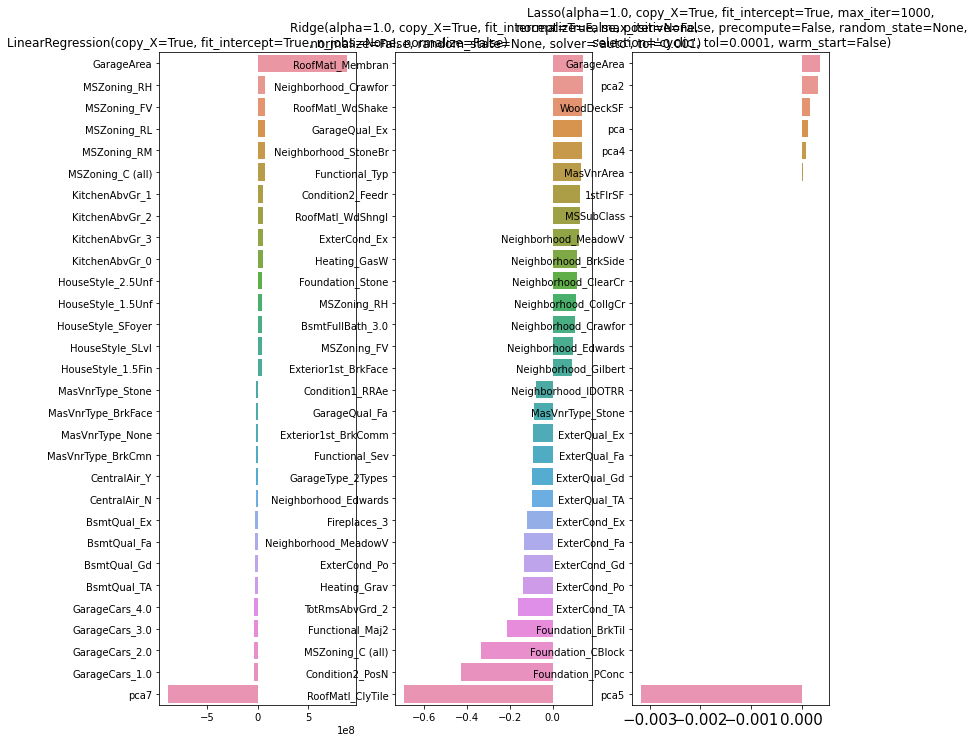

In [130]:
# 각 모델에 따른 회귀 계수 값을 시각화하기 위해 5개의 열로 된 맷플롯립 축 생성
models = [lr, ridge, lasso]
    
fig , axs = plt.subplots(figsize=(12,12) , nrows=1 , ncols=3)
# 각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 DataFrame 생성  
coef_df = pd.DataFrame()
plt.xticks(fontsize=15)

# alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장. pos는 axis의 위치 지정
for pos , model in enumerate(models) :
    model.fit(X_train, y_train)
    # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가.  
    coef = pd.Series(data=model.coef_ , index=X_train.columns )
    coef_head = coef.sort_values(ascending=False).head(15)
    coef_tail = coef.sort_values(ascending=False).tail(15)
    coef = pd.concat([coef_head, coef_tail])
    coef_df[model] = coef
    # 막대 그래프로 각 alpha 값에서의 회귀 계수를 시각화. 회귀 계수값이 높은 순으로 표현--------------------추가코드
    coef = coef.sort_values(ascending=False)
    axs[pos].set_title(model)
    
#     axs[pos].set_xlim(-0.2,0.2)
    sns.barplot(x=coef.values , y=coef.index, ax=axs[pos])
# for 문 바깥에서 맷플롯립의 show 호출 및 alpha에 따른 피처별 회귀 계수를 DataFrame으로 표시

plt.show()

### 모델 검증 및 튜닝

In [131]:
myprm = {'alpha':[0.05,0.1,0.5,1.0,3.0,10.0, 20.0]}
best_model = GridSearchCV(ridge, param_grid=myprm,
             scoring="neg_mean_squared_error",verbose=0,
             refit=True, cv=5)
best_model.fit(X_train, y_train)
print("베스트 점수:",best_model.best_score_)
print("베스트 파라미터:",best_model.best_params_)

best_pred = best_model.predict(X_test)

베스트 점수: -0.02158964993293076
베스트 파라미터: {'alpha': 10.0}


- best_param 중심으로 튜닝 값 재조정
- alpha값 변화를 시각화해서 확인

In [132]:
print("submit시 제출할 예측 집값(로그변환값) :\n", best_pred[:5])
print("원본값으로 변환:\n", np.round(np.expm1(best_pred),0)[:5])

submit시 제출할 예측 집값(로그변환값) :
 [11.6711258  11.97764181 12.08616719 12.16941953 12.15987376]
원본값으로 변환:
 [117139. 159155. 177400. 192801. 190969.]


In [133]:
myprm = [1.0, 1,5,8.0,9.0,10.0,11.0,12.0,15,20,50]
score_list = []
for ap in myprm:
    ridge = Ridge(alpha=20)
    neg_mse_scores5 = cross_val_score(ridge, X_train, y_train, 
                scoring="neg_mean_squared_error", cv = 5)
    rmse_scores5  = np.sqrt(-1 * neg_mse_scores5)
    avg_rmse = np.mean(rmse_scores5)
    print(avg_rmse)  
    score_list.append(avg_rmse)

0.14567039973456436
0.14567039973456436
0.14567039973456436
0.14567039973456436
0.14567039973456436
0.14567039973456436
0.14567039973456436
0.14567039973456436
0.14567039973456436
0.14567039973456436
0.14567039973456436


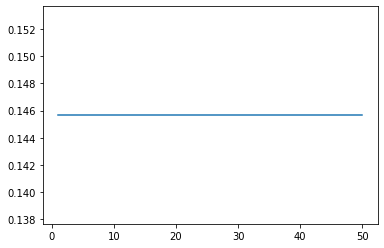

In [134]:
plt.plot(myprm, score_list)
plt.show()

In [135]:
sub_df = pd.read_csv("price_submission.csv")
mydic = {"Id": sub_df["Id"],
         "SalePrice" : np.round(np.expm1(best_pred),0)
         }
sub_df = pd.DataFrame(mydic, index=None)
print(sub_df.head())
sub_df.to_csv("sample_submission22.csv", index=None)

FileNotFoundError: ignored

### Ridge 추가

In [136]:
ridge = Ridge(alpha=10)

In [137]:
ridge.fit(X_train,y_train)

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

### ElasticNet 추가

In [138]:
from sklearn.linear_model import ElasticNet

In [139]:
param_e = {'alpha' :[0.003, 0.005, 0.01, 0.1], 'l1_ratio':[0.05,0.1,0.3], 'normalize':[True,False]}

In [140]:
Enet = GridSearchCV(ElasticNet(alpha=0.003, l1_ratio=0.1, normalize=False),param_e, scoring = 'neg_mean_squared_error')

In [141]:
Enet.fit(X_train,y_train)
print("베스트 파라미터:",Enet.best_params_)

베스트 파라미터: {'alpha': 0.003, 'l1_ratio': 0.1, 'normalize': False}


In [142]:
pred_Enet = Enet.predict(X_test)

In [ ]:
print("submit시 제출할 예측 집값(로그변환값) :\n", pred_Enet[:5])
print("원본값으로 변환:\n", np.round(np.expm1(pred_Enet),0)[:5])

In [ ]:
sub_df = pd.read_csv(d_path + "sample_submission.csv")
mydic = {"Id": sub_df["Id"],
         "SalePrice" : np.round(np.expm1(pred_Enet),0)
         }
sub_df = pd.DataFrame(mydic, index=None)
print(sub_df.head())
sub_df.to_csv(d_path + "price_submission2.csv", index=None)

### LGBMRegressor

In [143]:
from lightgbm import LGBMRegressor

In [212]:
param_lgb = param_grid = [{
    'n_estimators': [500, 600], 
    'max_depth': [10, 11,13],
    'num_leaves': [8, 10,12],
}]

In [213]:
lgb = GridSearchCV(LGBMRegressor(),param_lgb, scoring = 'neg_mean_squared_error')

In [214]:
lgb.fit(X_train,y_train)
print("베스트 파라미터:",lgb.best_params_)

베스트 파라미터: {'max_depth': 11, 'n_estimators': 500, 'num_leaves': 10}


In [ ]:
pred_lgb = lgb.predict(X_test)

### XGBoost

In [164]:
from xgboost import XGBRegressor

In [188]:
param_x = [{
            'learning_rate':[ 0.1],    # 0.09
            'max_depth':[20,25],               # 20
            'n_estimator':[90, 100]              # 90
            }]

In [189]:
xgb = GridSearchCV(XGBRegressor(objective='reg:squarederror'),param_x, scoring = 'neg_mean_squared_error')    # XGBRegressor는 objective='reg:squarederror' 주의 해야한다.

In [190]:
xgb.fit(X_train, y_train)
print("베스트 파라미터:",xgb.best_params_)

베스트 파라미터: {'learning_rate': 0.09, 'max_depth': 20, 'n_estimator': 90}


### 앙상블(Voting)
ElasticNet, LGBM, Ridge, XGBoost

In [180]:
from sklearn.ensemble import VotingRegressor

최적 파라미터 설정

In [219]:
# ridge = Ridge(alpha=10)
# lgb = LGBMRegressor(max_depth=11, n_estimators=600,num_leaves=10)
# enet = ElasticNet(alpha=0.003, l1_ratio=0.1, normalize=False)
# xgb = XGBRegressor(objective='reg:squarederror', learning_rate=0.1, max_depth=25, n_estimator=100)

ridge = Ridge(alpha=10)
lgb = LGBMRegressor(max_depth=11, n_estimators=550,num_leaves=10)
enet = ElasticNet(alpha=0.003, l1_ratio=0.09, normalize=False)
xgb = XGBRegressor(objective='reg:squarederror', learning_rate=0.1, max_depth=25, n_estimator=100)

In [220]:
Enet.fit(X_train,y_train)
lgb.fit(X_train,y_train)
ridge.fit(X_train,y_train)
xgb.fit(X_train,y_train)

estimators = [('Enet', Enet), ('lgb', lgb), ('ridge', ridge), ('xgb', xgb)]


# 평점 예측 모형
reg_rating = VotingRegressor(estimators)
reg_rating.fit(X_train, y_train)

reg_pred = reg_rating.predict(X_test)

In [221]:
sub_df = pd.read_csv(d_path + "sample_submission.csv")
mydic = {"Id": sub_df["Id"],
         "SalePrice" : np.round(np.expm1(reg_pred),0)
         }
sub_df = pd.DataFrame(mydic, index=None)
print(sub_df.head())
sub_df.to_csv(d_path + "price_submission1.csv", index=None)

     Id  SalePrice
0  1461   121495.0
1  1462   159953.0
2  1463   182478.0
3  1464   194812.0
4  1465   189225.0
